<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quantile-Regression" data-toc-modified-id="Quantile-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quantile Regression</a></span><ul class="toc-item"><li><span><a href="#Objective-Function" data-toc-modified-id="Objective-Function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objective Function</a></span></li><li><span><a href="#Quantile-Regression-With-LightGBM" data-toc-modified-id="Quantile-Regression-With-LightGBM-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Quantile Regression With LightGBM</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))
from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,lightgbm

Ethen 2019-01-27 09:15:00 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
pandas 0.23.4
sklearn 0.20.2
matplotlib 3.0.2
lightgbm 2.1.0


# Quantile Regression

When working with real-world regression model, often times knowing the uncertainty behind each point estimation can make our predictions more actionable in a business settings. One method of going from a single point estimation to a range estimation or so called prediction interval is known as **Quantile Regression**.

For example, consider historical sales of an item under a certain circumstance are (10000, 10, 50, 100). Standard least squares method would gives us an estimate of 2540. If we were to restock based on that prediction, we would likely going to significantly overstock 75% of the time. But if we estimate the quantiles of the data distribution, the estimated 5th, 50th, and 95th percentiles are 16, 75, 8515, which are much more informative than the 2540 single estimation. After producing these range estimation we can also [leverage some business context that might be hard to incorporate into our data analysis](https://simplystatistics.org/2018/12/19/the-netflix-data-war/) and use that to determine the final business decision.

## Objective Function

As we might recall, for linear regression or so called ordinary least squares (OLS), we assume the relationship between our input variable $X$ and our output label $Y$ can be modeled by a linear function. 

\begin{align}
Y = \theta_0 + \theta_1X_1 + \theta_2X_2 + \ldots + \theta_pX_p + \epsilon
\end{align}

And the most common objective function is squared error.

\begin{align}
L = (y - X\theta)^2
\end{align}

With quantile regression, we have an additional parameter $\tau$, which specifies the $\tau_{th}$ quantile of our target variable $Y$ that we're interested in modeling, where $\tau \in (0, 1)$ and our objective function becomes:

\begin{align}
L &=
\begin{cases}
\tau(y - X\theta), \; if \; y - X\theta \geq 0 \\
(\tau - 1)(y - X\theta), \; if \; y - X\theta < 0
\end{cases}
\end{align}

Let's try and get some intuition of what this objective function is telling us. The quantile loss differs depending on the evaluated quantile. Such that more negative errors are penalized more when we specify a higher quantiles and more positive errors are penalized more for lower quantiles. To confirm that this is actually the case, the code chunk below simulates the quantile loss at different quantile values.

In [3]:
def compute_quantile_loss(y_true, y_pred, quantile):
    """
    
    Parameters
    ----------
    y_true : 1d ndarray
        Target value.
        
    y_pred : 1d ndarray
        Predicted value.
        
    quantile : float, 0. ~ 1.
        Quantile to be evaluated, e.g., 0.5 for median.
    """
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)

In [4]:
# Suppose we've made a prediction for a single point with a true value of zero,
# and our predictions range from -1 to +1 that is, our errors also range from -1 to +1.
n_samples = 1000
y_true = np.zeros(n_samples)
y_pred = np.linspace(-1, 1, n_samples)

quantiles = [0.1, 0.5, 0.9]
quantile_losses = [
    compute_quantile_loss(y_true, y_pred, quantile)
    for quantile in quantiles
]

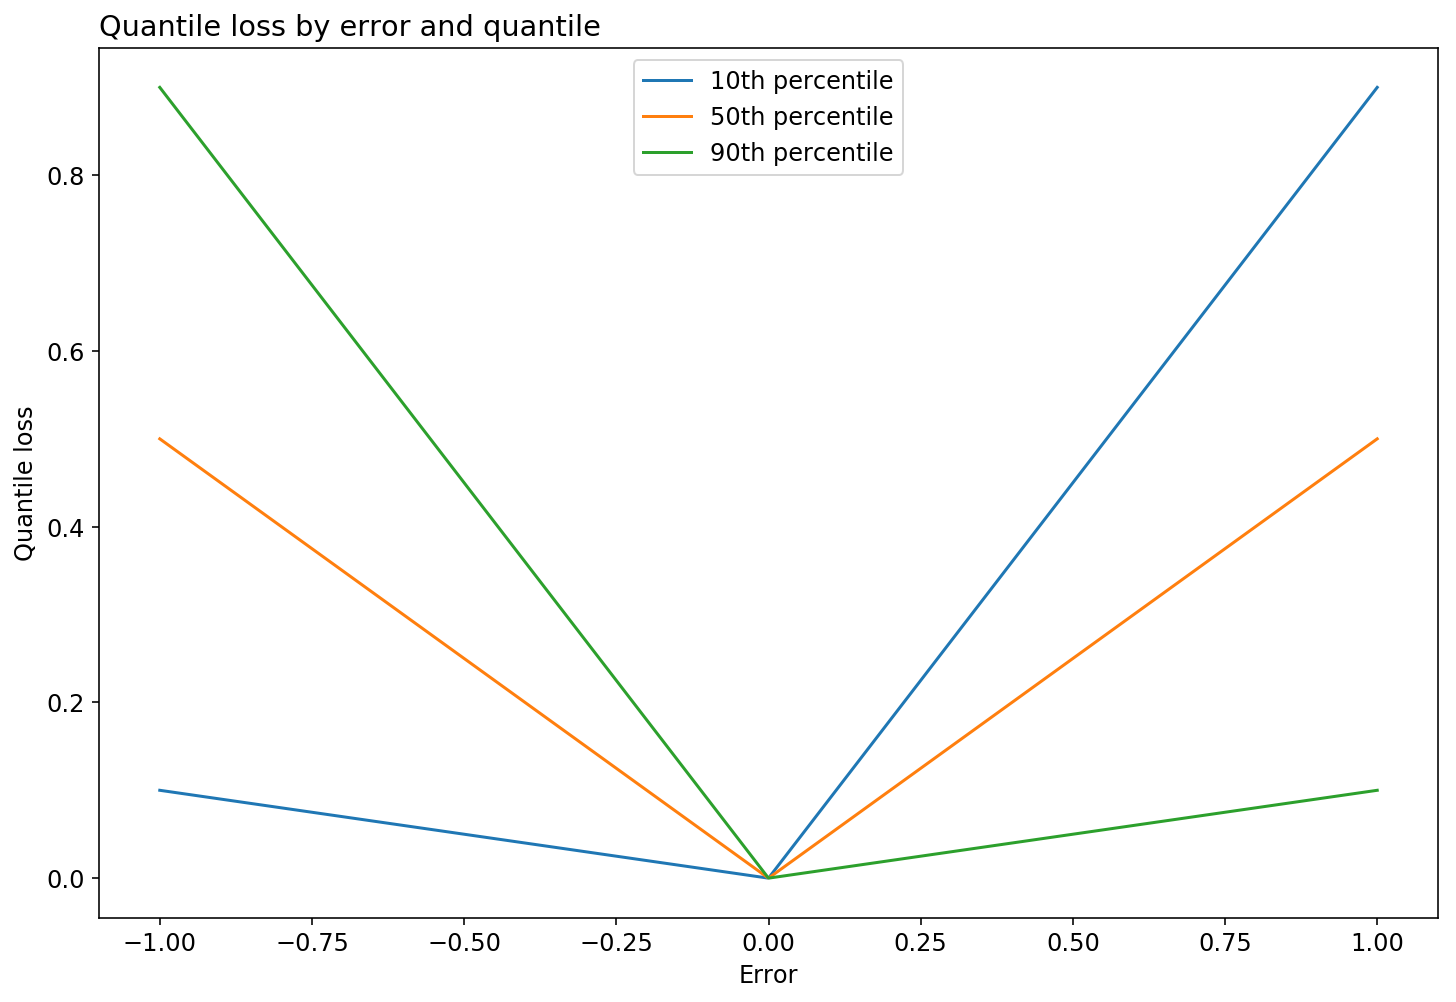

In [5]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12


for quantile_loss in quantile_losses:
    plt.plot(y_pred, quantile_loss)

plt.legend([str(int(q * 100)) + 'th percentile' for q in quantiles])
plt.xlabel('Error')
plt.ylabel('Quantile loss')
plt.title('Quantile loss by error and quantile', loc='left')
plt.show()

Let's look at each line separately:

- The orange line shows the median, which is symmetric around zero. The median aims to bisect the set of predictions, so we want to weigh underestimates equally to overestimates. As it turns out choosing a quantile of 0.5 is equivalent to modeling the absolute values of the residuals $\big| (y - X\theta) \big|$.
- The blue line shows the 10th percentile, which assigns a lower loss to negative errors and a higher loss to positive errors. The 10th percentile means we think there's a 10 percent chance that the true value is below the predicted value, so it makes sense to assign less weight to underestimates than to overestimates.
- The green blue line shows the 90th percentile, which is the opposite of the 10th percentile.

## Quantile Regression With LightGBM

In the following section, we generate a sinoide function + random gaussian noise, with 80% of the data points being our training samples (blue points) and the rest being our test samples (red points). Generating a 1 dimension fake data allows us to easily visualize it and gain intuition on what sort of black magic our algorithm is doing.

In [6]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)


def gen_data(low, high, n_samples, scale=4, test_size=0.2, random_state=3):
    """generate training and testing data from the ground truth function"""
    np.random.seed(15)
    X = np.random.uniform(low, high, size=n_samples)

    # generate the response from the ground truth function and add
    # some random noise to it, scale controls the variance of the noise.
    y = ground_truth(X) + np.random.normal(scale=scale, size=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test


def plot_data(x_plot, X_train, X_test, y_train, y_test, low, high):
    """plot training and testing data"""
    s = 15
    plt.plot(x_plot, ground_truth(x_plot), alpha=0.5, label='ground truth')
    plt.scatter(X_train, y_train, s=s, alpha=0.2)
    plt.scatter(X_test, y_test, s=s, alpha=0.2, color='red')
    plt.xlim((low, high))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.show()

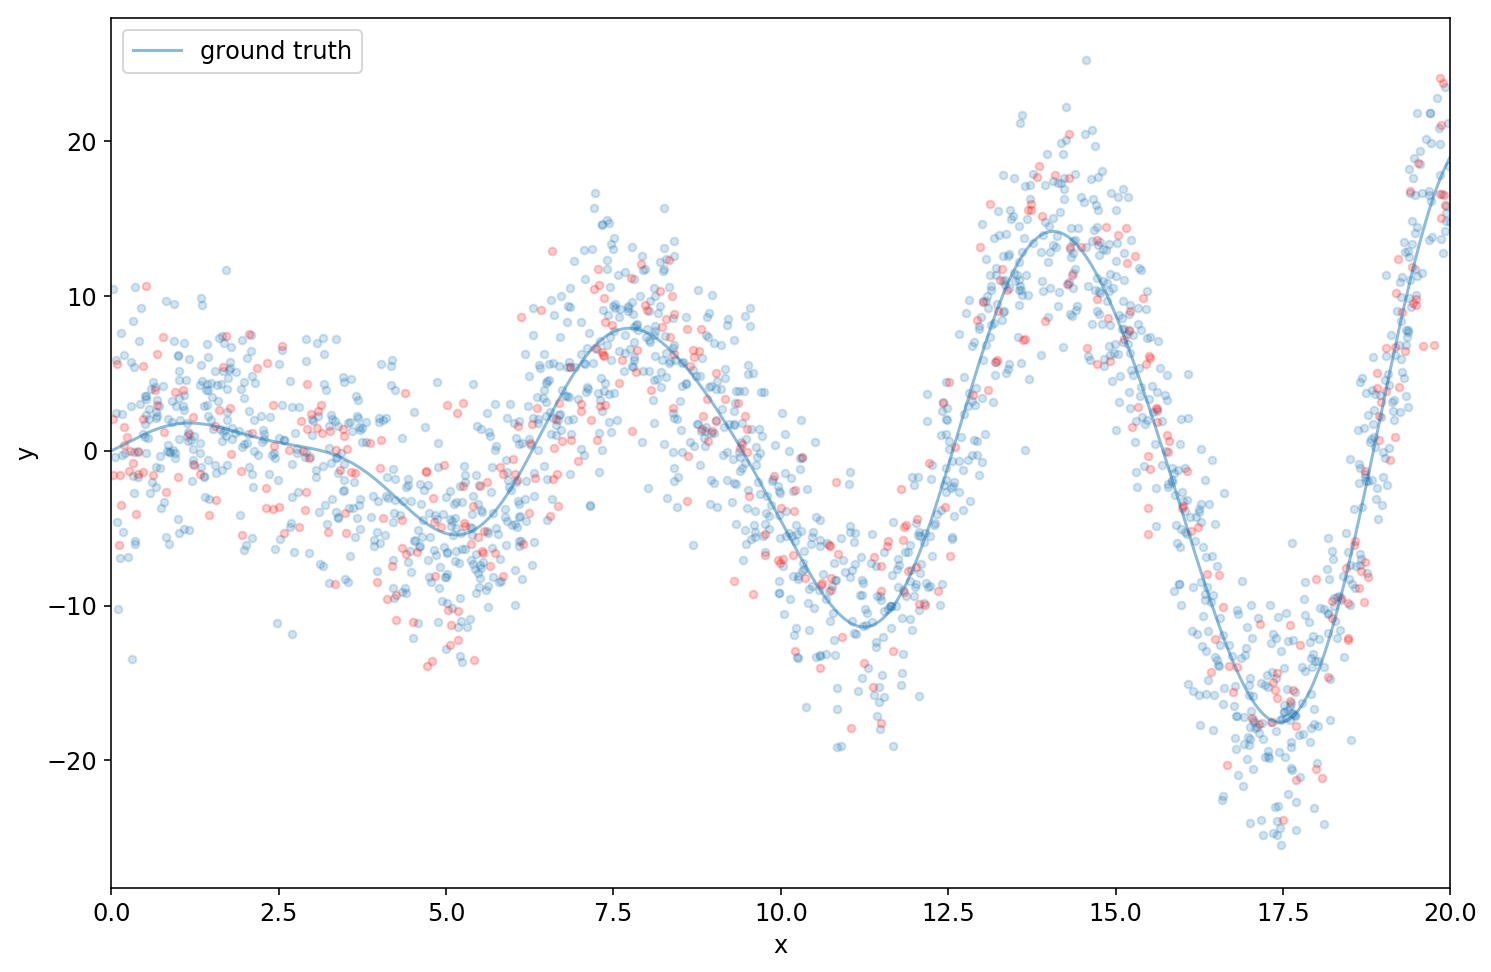

In [7]:
low = 0
high = 20
x_plot = np.linspace(low, high, 500)

n_samples = 2000
X_train, X_test, y_train, y_test = gen_data(low=low, high=high, n_samples=n_samples)
plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

We first use the squared error loss as our objective function to train our tree model and visualize the predicted value versus the ground truth.

In [8]:
# feel free to do some hyperparamter tuning,
# these parameters were picked randomly
lgb_params = {
    'n_jobs': 1,
    'max_depth': 4,
    'min_data_in_leaf': 10,
    'subsample': 0.9,
    'n_estimators': 80,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt'
}
lgb_l2 = LGBMRegressor(objective='regression', **lgb_params)
lgb_l2.fit(X_train[:, np.newaxis], y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       learning_rate=0.1, max_depth=4, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
       n_estimators=80, n_jobs=1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.9, subsample_for_bin=200000, subsample_freq=1)

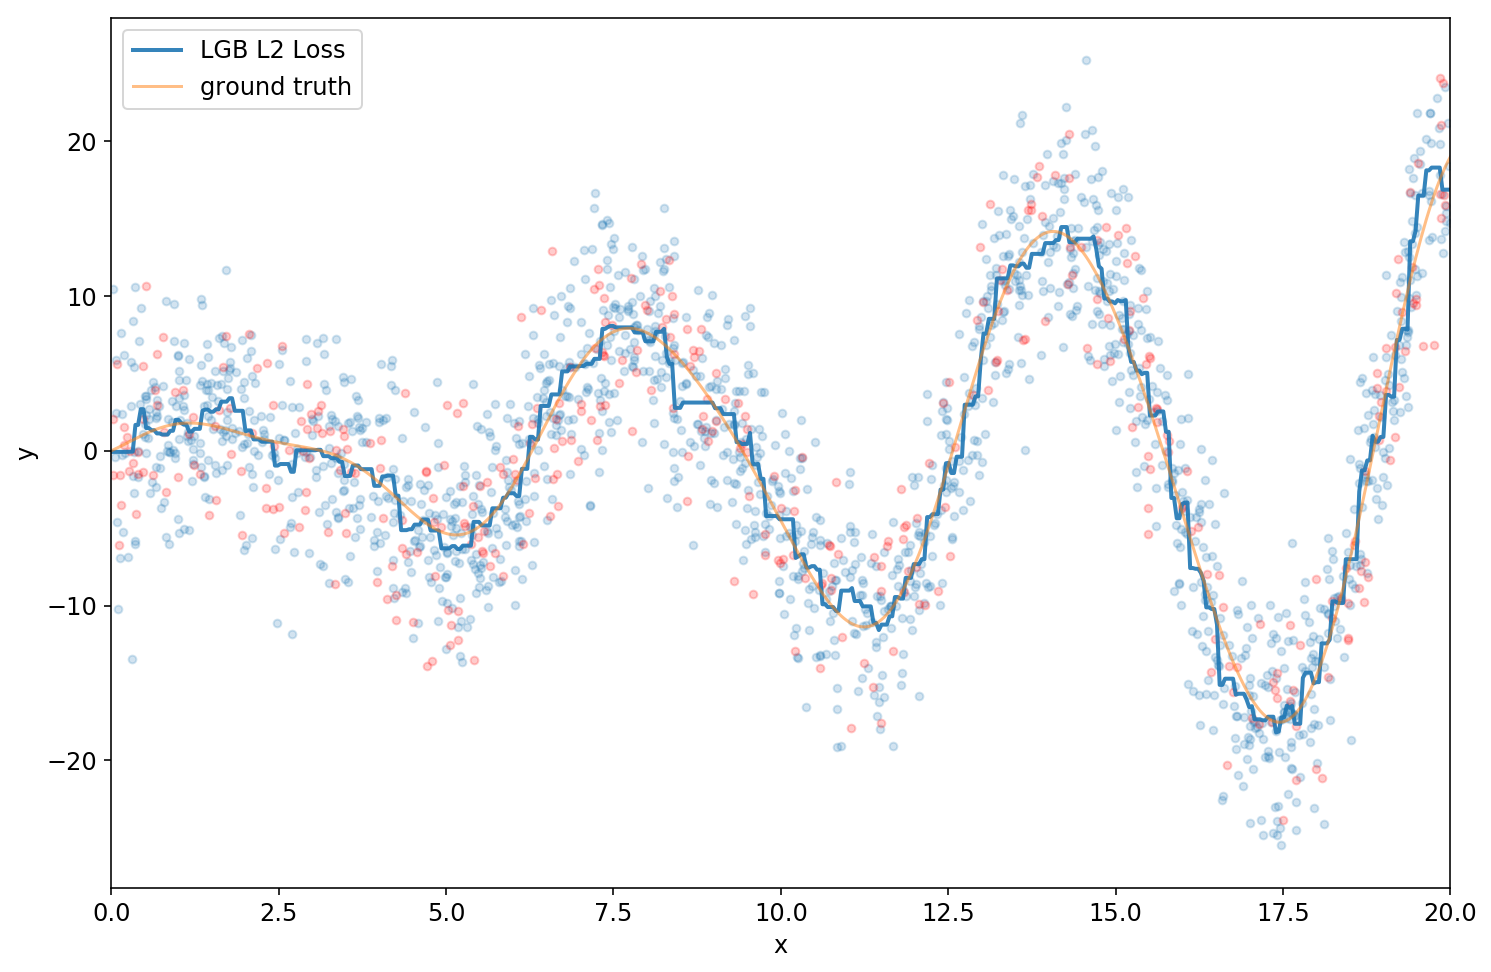

In [9]:
plt.plot(x_plot, lgb_l2.predict(x_plot[:, np.newaxis]),
         label='LGB L2 Loss', alpha=0.9, linewidth=2)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

For tree models, it's not possible to predict more than one value per model. Therefore what we'll do is training different models which predict different quantile values. Then just as before, we plot the prediction of various models that were specified to optimize on different quantile values against the ground truth.

In [10]:
quantile_alphas = [0.1, 0.5, 0.9]

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha, **lgb_params)
    lgb.fit(X_train[:, np.newaxis], y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

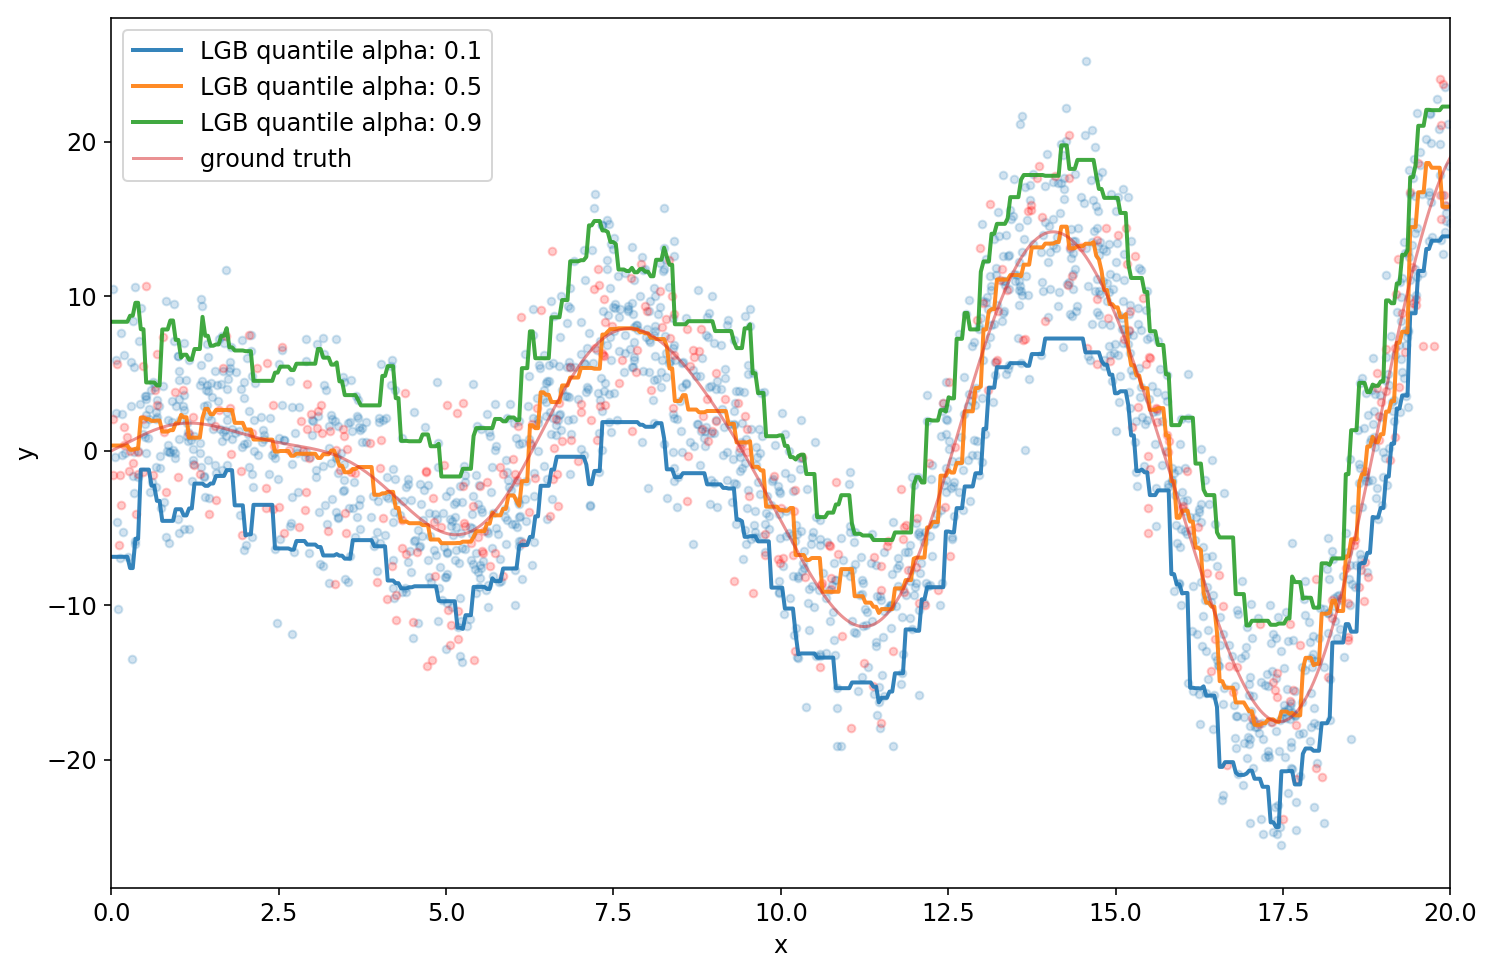

In [11]:
for quantile_alpha, lgb in lgb_quantile_alphas.items():
    plt.plot(x_plot, lgb.predict(x_plot[:, np.newaxis]),
             label='LGB quantile alpha: {}'.format(quantile_alpha),
             alpha=0.9, linewidth=2)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

A quick inspection of the plot above shows that by training a model using 10% quantile and 90% quantile, we were able to generate a prediction interval for our predictions.

Like all other machine learning tasks, we can check how our model performed by looking at some evaluation metrics. Since our quantile loss differs depending on the quantile we've specified. Hence, we'll look at the quantile loss at different levels for each of our model. 

In [12]:
def create_loss_comparision():
    model_name = []
    columns = []
    results = []

    y_true = ground_truth(x_plot[:, np.newaxis])
    for quantile_alpha, lgb in lgb_quantile_alphas.items():
        quantile_str = str(int(quantile_alpha * 100))
        columns.append('quantile_' + quantile_str)
        model_name.append('lgb_' + quantile_str)

        y_pred = lgb.predict(x_plot[:, np.newaxis])
        result = [
            compute_quantile_loss(y_true, y_pred, quantile).mean()
            for quantile in quantile_alphas
        ]
        results.append(result)


    df_results = pd.DataFrame(results, columns=columns)
    df_results['model'] = model_name
    return df_results


df_results = create_loss_comparision()
df_results

,quantile_10,quantile_50,quantile_90,model
0,2.923923,4.982469,7.041016,lgb_10
1,4.554619,4.537889,4.521160,lgb_50
2,7.210369,5.038287,2.866205,lgb_90


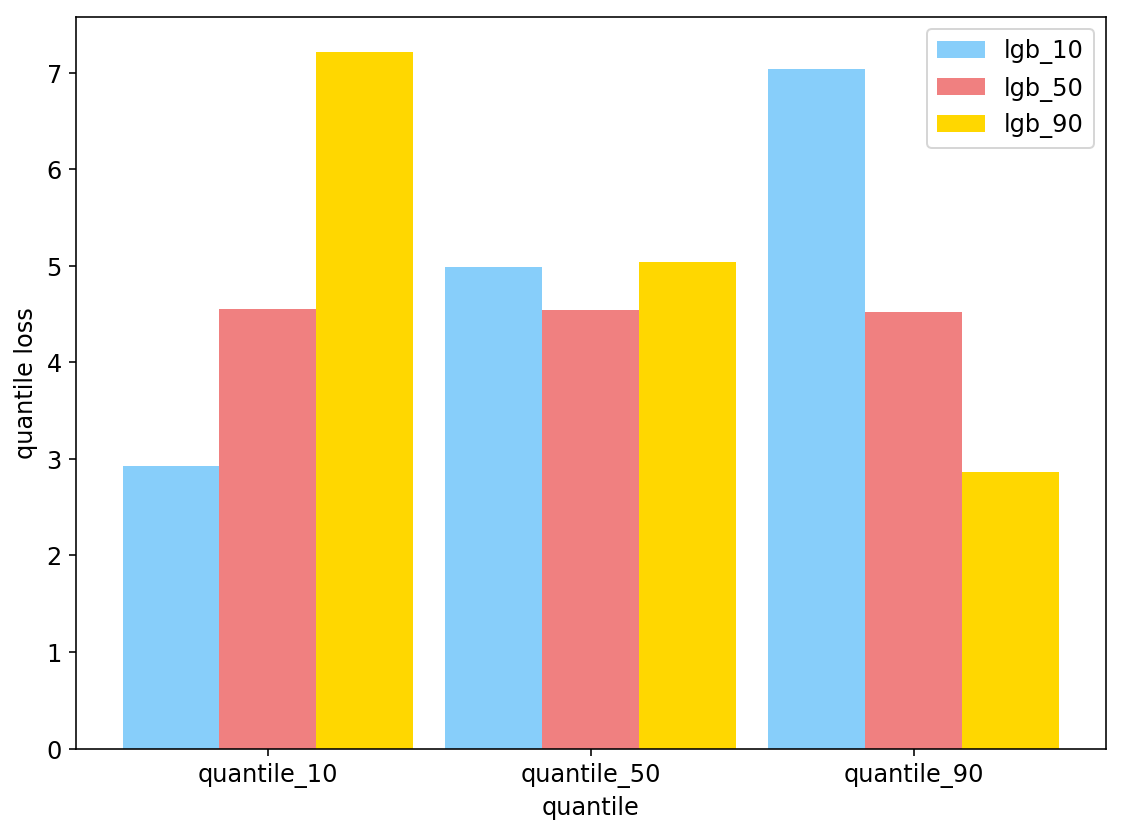

In [13]:
def score_barplot(df_results, model_col='model', figsize=(8, 6)):
    metrics_cols = ['quantile_10', 'quantile_50', 'quantile_90']
    colors = ['lightskyblue', 'lightcoral', 'gold']

    width = 0.3
    ind = np.arange(len(metrics_cols))

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    n_rows = df_results.shape[0]
    for i in range(n_rows):
        x = ind + (i * width)
        height = df_results.loc[i, metrics_cols]
        label = df_results.loc[i, model_col]
        ax.bar(x, height, width, label=label, color=colors[i])

    half_width = (n_rows // 2) * width
    ax.set_xticks(ind + half_width)
    ax.set_xticklabels(metrics_cols)
    ax.set_ylabel('quantile loss')
    ax.set_xlabel('quantile')
    ax.legend()
    plt.tight_layout()
    plt.show()
    

score_barplot(df_results)

Not surprisingly, model that were specified to optimized for quantile 10%/50%/90% performed better on quantile 10%/50%/90% loss respectively.

We can also apply quantile regression's objective function and use it to train other sorts of models such as deep learning, but we won't touch upon it here. The reference section includes links that shows how to achieve this with various modern deep learning frameworks.

Mentions of quantile regression applied in practice. [Blog: How Instacart delivers on time (using quantile regression)](https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb)

> Instacart has a model that predicts delivery times, but they needed a way to account for how big the predicted error can be so that it is actually delivered on time. Even if our predictive model is unbiased, we are only correct on average. This prediction error, or what they termed as buffer time, needs to be high enough to cover the risk of lateness in most of the cases. But if the buffer is too high, they might lose efficiency by reducing the size of the feasible space of the optimization problem, as fewer shoppers might be considered for a given order. A quantile regression of 0.9 will give us an upper bound of the delivery time, that will be used to make sure the delivery will not be late 90% of the time

# Reference

- [Blog: Quantile Regression — Part 1, What is it and How does it work?](https://medium.com/the-artificial-impostor/quantile-regression-part-1-e25bdd8d9d43)
- [Blog: Quantile Regression — Part 2, An Overview of Tensorflow, Pytorch, LightGBM implementations](https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629)
- [Blog: Quantile regression, from linear models to trees to deep learning](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3)
- [Blog: Deep Quantile Regression](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)